# Testing our own numbers on the Models

In [1]:
import pandas as pd
import numpy as np
import joblib
import cv2
import matplotlib.pyplot as plt

In [2]:
img1 = (r'C:\Users\user\Desktop\School\MSAAI_501\Group_Projects\Gabes_Numbers\1.JPG') # gabe
img2 = (r'C:\Users\user\Desktop\School\MSAAI_501\Group_Projects\Gabes_Numbers\6.JPG') # gabe
img3 = (r'C:\Users\user\Desktop\School\MSAAI_501\Group_Projects\Gabes_Numbers\2.JPG') # gabe
img4 = (r'C:\Users\user\Desktop\School\MSAAI_501\Group_Projects\Philips_Numbers\5.png') # philip 
img5 = (r'C:\Users\user\Desktop\School\MSAAI_501\Group_Projects\Philips_Numbers\7.png') # philip
img6 = (r'C:\Users\user\Desktop\School\MSAAI_501\Group_Projects\Philips_Numbers\9.png') # philip
img7 = (r'C:\Users\user\Desktop\School\MSAAI_501\Group_Projects\Sydneys_Numbers_pngs\2.jpg') # Syd
img8 = (r'C:\Users\user\Desktop\School\MSAAI_501\Group_Projects\Sydneys_Numbers_pngs\0.jpg') # Syd
img9 = (r'C:\Users\user\Desktop\School\MSAAI_501\Group_Projects\Sydneys_Numbers_pngs\8.jpg') # Syd

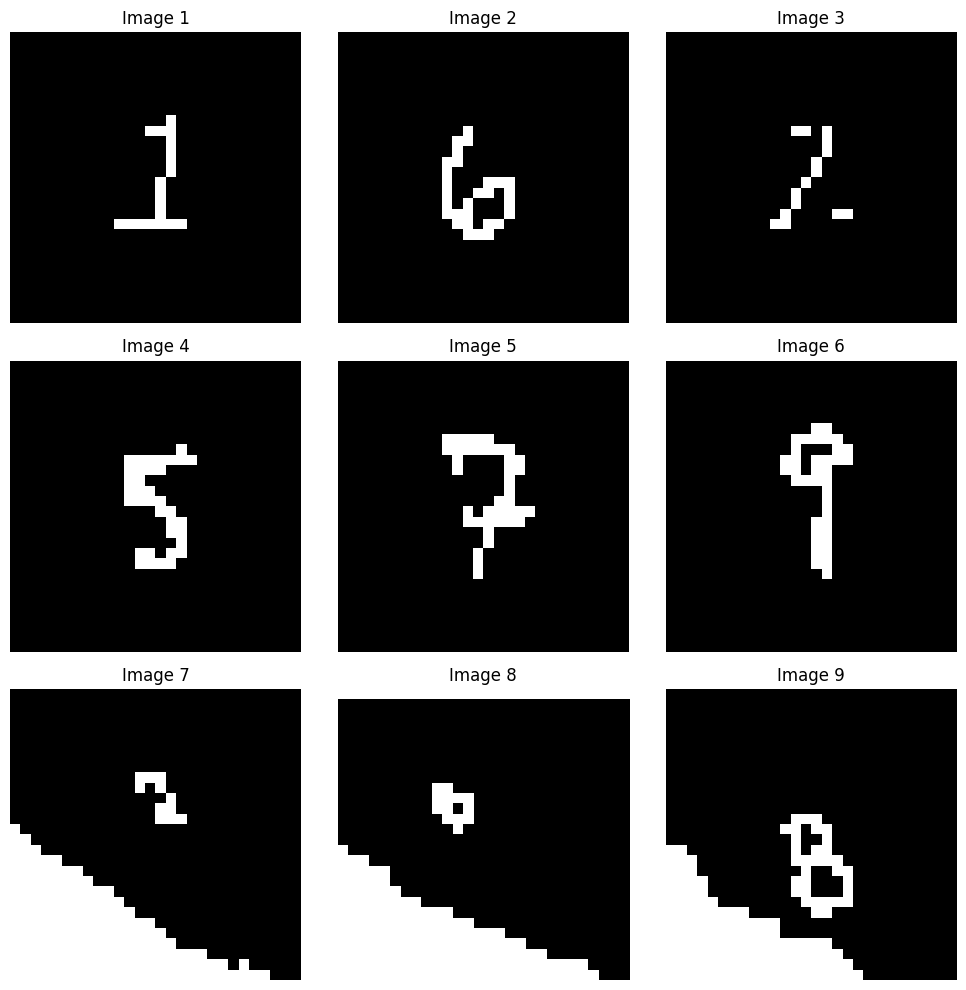

In [3]:
# List of image file paths
img_paths = [img1, img2, img3, img4, img5, img6, img7, img8, img9]

# Function to read images from paths and convert to grayscale
def grey_scale(img_paths):
    grey_list = []
    for path in img_paths:
        img = cv2.imread(path)  # Read the image from the file path
        if img is not None:  # Check if the image was loaded correctly
            grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            grey_list.append(grey)
        else:
            print(f"Failed to load image from {path}")
    return grey_list

# Function to resize images
def resize(grey_list):
    resized_list = []
    for img in grey_list:
        resized = cv2.resize(img, (28, 28), interpolation=cv2.INTER_AREA)
        resized_list.append(resized)
    return resized_list

# Function to convert images to black and white
def black_white(resized_list):
    black_white_list = []
    for img in resized_list:
        _, black_white = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
        black_white_list.append(black_white)
    return black_white_list

# Function to invert colors (black to white, white to black)
def invert_colors(bw_list):
    inverted_list = []
    for img in bw_list:
        inverted = 255 - img  # Invert colors
        inverted_list.append(inverted)
    return inverted_list

# Applying the functions
grey_list = grey_scale(img_paths)
resized_list = resize(grey_list)
black_white_list = black_white(resized_list)
inverted_list = invert_colors(black_white_list)

# Displaying the images
plt.figure(figsize=(10, 10))
for i, img in enumerate(inverted_list, 1):
    plt.subplot(3, 3, i)
    plt.imshow(img, cmap='gray')
    plt.title(f'Image {i}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [4]:
flattened_images = [img.flatten() for img in inverted_list]

# Printing the first few elements of each flattened image to check
for i, img in enumerate(flattened_images, 1):
    print(f"Image {i}: {img[:10]}...")

Image 1: [0 0 0 0 0 0 0 0 0 0]...
Image 2: [0 0 0 0 0 0 0 0 0 0]...
Image 3: [0 0 0 0 0 0 0 0 0 0]...
Image 4: [0 0 0 0 0 0 0 0 0 0]...
Image 5: [0 0 0 0 0 0 0 0 0 0]...
Image 6: [0 0 0 0 0 0 0 0 0 0]...
Image 7: [0 0 0 0 0 0 0 0 0 0]...
Image 8: [255 255 255 255 255 255 255 255 255 255]...
Image 9: [0 0 0 0 0 0 0 0 0 0]...


In [5]:
# Paths to your saved models
SVM_path = r'C:\Users\user\Desktop\School\MSAAI_501\Group_Projects\mnist_svm_by_Gabe.joblib'
KNN_path = r'C:\Users\user\Desktop\School\MSAAI_501\Group_Projects\knn_mnist_by_gabe.joblib'

# Loading the models
SVM_model = joblib.load(SVM_path)
KNN_model = joblib.load(KNN_path)

# Predicting the numbers using the models for the first 6 images
svm_predictions = SVM_model.predict(flattened_images[:6])
knn_predictions = KNN_model.predict(flattened_images[:6])

# Printing the predictions
for i in range(6):
    print(f"For image {i+1}, the KNN predicted {knn_predictions[i]} and the SVM predicted {svm_predictions[i]}")



c:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


For image 1, the KNN predicted 4 and the SVM predicted 7
For image 2, the KNN predicted 6 and the SVM predicted 7
For image 3, the KNN predicted 4 and the SVM predicted 7
For image 4, the KNN predicted 1 and the SVM predicted 7
For image 5, the KNN predicted 8 and the SVM predicted 7
For image 6, the KNN predicted 4 and the SVM predicted 7


In [10]:
%%html
<canvas id="canvas" width="280" height="280" style="border:1px solid #000000; background-color: black;"></canvas>
<button id="saveButton">Save Image</button>
<p id="imageDataText" style="word-wrap: break-word;"></p>
<script>
    var canvas = document.getElementById('canvas');
    var ctx = canvas.getContext('2d');
    var mousePressed = false;
    var lastX, lastY;

    function draw(x, y, isDrawing) {
        if (isDrawing) {
            ctx.beginPath();
            ctx.strokeStyle = 'white';
            ctx.lineWidth = 20;
            ctx.lineJoin = 'round';
            ctx.moveTo(lastX, lastY);
            ctx.lineTo(x, y);
            ctx.closePath();
            ctx.stroke();
        }
        lastX = x;
        lastY = y;
    }

    canvas.addEventListener('mousedown', function(e) {
        mousePressed = true;
        draw(e.offsetX, e.offsetY, false);
    });

    canvas.addEventListener('mousemove', function(e) {
        if (mousePressed) {
            draw(e.offsetX, e.offsetY, true);
        }
    });

    canvas.addEventListener('mouseup', function() {
        mousePressed = false;
    });

    canvas.addEventListener('mouseleave', function() {
        mousePressed = false;
    });

    document.getElementById('saveButton').addEventListener('click', function() {
        var image_data_url = canvas.toDataURL('image/png');
        document.getElementById('imageDataText').innerText = image_data_url;
    });
</script>

In [11]:
import base64
import io
from PIL import Image
import numpy as np
import joblib

# Manually paste the copied data URL string here (it will be very long)
image_data_url = 'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAARgAAAEYCAYAAACHjumMAAAAAXNSR0IArs4c6QAAEY5JREFUeF7tnUuMpGUVht/jACJGuQRBxAEUTCAuVCLKQgNEIurK20ZURGNQoqx0BFxJTGRgdGFiIuAdI668rAgiJOBCZfAWF4B3BURRUDMGRJjhmF9rAOkeurrqfF/VW//TSa+m/vOd/znvPHNqqro6xBcEIACBRgSiUV3KQgACEBCCIQQQgEAzAgimGVoKQwACCIYMQAACzQggmGZoKQwBCCAYMgABCDQjgGCaoaUwBCCAYMgABCDQjACCaYaWwhCAAIIhAxCAQDMCCKYZWgpDAAIIhgxAAALNCCCYZmgpDAEIIBgyAAEINCOAYJqhpTAEIIBgyAAEINCMAIJphpbCEIAAgiEDEIBAMwIIphlaCkMAAgiGDEAAAs0IIJhmaCkMAQggGDIAAQg0I4BgmqGlcA8CmXmppFMknSTpyMmZ90q6XdKtEXFxjz44Y30CCIZkWBLIzEEq10o6fIMbuE/SGyLiVssbNW8awZgPcIztZ+aVks7b5L1fFRHv2+Q1PHxOAghmToBc3pdAZn5Y0o4ZT90WEZ+c8Voum4EAgpkBGpcshkBmHi/p13OefkJE/GbOGlw+JQEEMyUoHrZ4Apn5O0nHzdnJ7yPiBXPW4PIpCSCYKUHxsMUSyMzLJW0r6mJHRHykqBZlnoIAgiEeFgQy825JRxc1+8eIeH5RLcogGDLgTiAzH5a0f9F9PBIRBxTVosxYBZOZ75b0cklbJb1w8v1zSddJ+sHwHRG7SMjyE8jMrOwyItjeK4Huo9ZKQs7MQSoXSXrLBgx/JekDEfHdDqw5Yg4CCGYOeAu8dOUEk5kfk3ShpAOn5Lpb0vsi4otTPp6HLYAAglkA9IIjV0owmflOSVfPyOWSiBjkxNcSEkAwSziUKVpaGcFk5hmShqc6W6a47/Ue8pCkV0fEj2a8nssaEqgWjKSzI+LrDVumtKSVEExmHiVpp6R5X3r8RkS8lWQsH4EGguENdx3GvCqCuUxS1Run3hMRX+rAniM2QaCBYIbTL4iIz2yiDR66SQL2gsnMQyTdI+kZm7z3fT38iog4v6gWZYoINBLMLRFxalGLlFmHwCoIZvvkVaOqAV8XEa+vKkadGgKNBPPPiHh2TYdUWY/AKgjml5JeVDjeOyJi+HQ0vpaIQCPB7ImI/ZboNleulVUQTOVbyIcBPxQRVU+3Vi4wi7qhRoIR7+htO9FVEEzpW8gl8by8beZmqo5gZsK28IsQzNoR8Ia7hcdybQMIZgmHMkVLCGYtpNdFxHemYMdDOhJAMB1hFx6FYNbCPJifsC5MWFEpBFMEsnMZBPMk4PynX+cETnkcgpkS1JI9DMEgmCWL5PrtIBiLMa1pEsEgGIvkIhiLMSGYjcbEU6SNCC3mzxHMYrjPeyobDBvMvBnqcn0rwUg6NCL+0eUmRngIgkEwFrFvKJjLImL4eFW+GhBAMAimQazqSzYUzM6IeGV9x1QcCCAYBGPxN6GhYHZFxMEWEAybRDAIxiK2DQWTEfE0CwiGTSIYBGMR24aC4SeqGyYAwSCYhvGqK41g6lj2rIRgEEzPvM18FoKZGd1CL0QwCGahAZz2cAQzLanlehyCQTDLlch9dINgLMa0pkkEg2AskotgLMaEYDYaEz+LtBGhxfw5glkM93lPZYNhg5k3Q12ubykYSUdExF+73MjIDkEwCMYi8o0Fc1ZEXG8BwqxJBINgLCLbWDBfjYhzLECYNYlgEIxFZBsL5raIeLEFCLMmEQyCsYhsY8HcHxGHW4AwaxLBIBiLyDYWzMMR8XQLEGZNIhgEYxHZxoLhBx4bpQDBIJhG0aoti2BqefaqhmAQTK+szXUOgpkL38IuRjAIZmHh28zBCGYztJbnsQgGwSxPGp+iEwRjMaY1TSIYBGORXARjMSYEs9GY+GHHjQgt5s8RzGK4z3sqGwwbzLwZ6nI9gumCufwQBINgykPVoiCCaUG1fU0Eg2Dap6zgBARTAHEBJRAMgllA7DZ/JILZPLNluALBIJhlyOGGPSCYDREt5QMQDIJZymA+uSkEYzGmNU0iGARjkVwEYzEmBLPRmHgfzEaEFvPnCGYx3Oc9lQ2GDWbeDHW5vrVgJJ0aEbd0uZkRHYJgEIxF3DsI5s6IONYChlGTCAbBWMS1g2AGDjsi4iMWQEyaRDAIxiKqnQRzR0ScZAHEpEkEg2AsotpJMP+OiAMtgJg0iWAQjEVUOwmGz+YtTgOCQTDFkWpTDsG04dq6KoJBMK0zVlI/M3dL2lJS7CmK8D6oWsIIBsHUJqpRtcz8s6QjG5V/rCyCqSWMYBBMbaIaVcvMnZJOaVQewTQCi2AQTKNo1ZbNzM9Ken9t1bXV2GBqCSMYBFObqEbVMvMoSfc0Ks8G0wgsgkEwjaJVX7bHK0lsMLVzQzAIpjZRDashmIZwG5VGMAimUbTqyyKYeqatKyIYBNM6Y2X1M/MRSfuVFVynEE+RaukiGARTm6iG1Xq8FwbB1A4QwSCY2kQ1rNbjvTAIpnaACAbB1CaqYbUe74VBMLUDRDAIpjZRDav1eC8MgqkdIIJBMLWJalyt9StJCKZ2gAgGwdQmqnE1BNMYcHF5a8Fk5lZJd1Yy4V+wSpr1tTJzj6Sn1Vf+X0XmX0vWXTCfk/TeSiQErJJmfa3M/LukQ+orI5gWTN0F82NJJxeC2RMRTd/IVdjrKEu1fqmaf2BqY+UumL9Iek4hknsj4rmF9ShVTKD1S9UIpnZg7oKpfuv4rRHxilrEVKsk0PqlagRTOS3JXTBZi0NXRMT5xTUpV0yg5StJCKZ2WAjm/3k+LyL+VIuYatUEEEw10Xb1bAWTmZdL2laJhn+9Kmm2q4Vg2rGtruwsmNslnVgJBMFU0mxXC8G0Y1td2VkwD0g6qBIIgqmk2a4WgmnHtrqys2AeHd54WQgkI6LZO0QL+xx9KQTjE4HKv6Bd77pByHZFxMFdb4LDZiLQYPaP9cEWO9NI9nkRgnkczc8j4iW1eKnWggCCaUG1TU0E8zjX7RFxcRvMVK0kgGAqabathWAmfFmN2watsjqCqaTZthaCQTBtE9agOoJpALVRSQQzUsFk5jMlvWrycRfDL5U/QtKBxa/MzRPb4cdAHpQ0/EDr9yV9XtLOiHgQwcyDte+1CGaBgsnM4aMhLpF0uqTjJj8Zvn/fCHDaEwnwVLk2Dwims2Ay86WSzpp8n9by09lqozKOagimds6WgsnM4RPNhk82K/uaJViZOXx2zLB57P0+VtIrJR0j6dDJ0w1LxmVgzQrNkgOzW+zarmX4M3O7pAsrSa0XrMz8oKR3SDpB0rMkHVB5JrWWjwCCqZ2Jq2BukVT6wVBPDFZmvk3SJyabSS1xqi01AQRTOx5XwQyvLjyjFoVulnTS5D9aLbkU8xhlOQRTO3bLv0gtX6asxUs1NwIIpnZiCKaWJ9XMCSCY2gEimFqeVDMngGBqB4hganlSzZwAgqkdIIKp5Uk1cwIIpnaACKaWJ9XMCSCY2gEimFqeVDMngGBqB4hganlSzZwAgqkdIIKp5Uk1cwIIpnaACKaWJ9XMCSCY2gEimFqeVDMngGBqB4hganlSzZwAgqkdIIKp5Uk1cwIIpnaAroKp/q2OtVS9qg0s/7XeZ98u4jYW/VnBCKZ26q6CuV/SYbUoFlpt+IDr6yV9W9L3IuK2hXZjcHhmXi5pW3WrCKaWqKtgbpD0mloUXas9PNkYfivpJkkfj4jdXTswPywzb5d0YvVtIJhaoq6CuVTSRbUoZq42bB/D04y/Sbpb0vBpe3+Q9Pu93xHx55mrc+G6BDLzAUkHFeN5NCK2FNccdTlLwQwTy8y/Sjp8AdP7o6SPRsTVCzibIycEMrPF/8PdExFHA7mOgLNghl8WtrMOxT4rDRvKLkk/k3RNRFzV4UyO2IBAo081vDEizgR+HQFbwUy2mCslnVeH47+V9kgatqNfSPphRCzLU7Hi2/Qu10gw2yPiYm8yy9W9tWAmkvmwpB0zYL1P0hcQyAzkluCSBoK5NyKG33PFVyEBe8FMJHO89N/fCjDN8+dhOzk3Iq4t5EipzgQaCOaMiBhe0eOrkMBKCGYvj8z8tKTXShp+w+LeX2uy95eo/0nSdRFxQSE/Si2IQLVgeHm6zSBXSjBtEFF1GQkgmGWcytqeEIzHnOjySQQQjEckEIzHnOgSwVhmAMFYjo2m2WA8MoBgPOZEl2wwlhlAMJZjo2k2GI8MIBiPOdElG4xlBhCM5dhomg3GIwMIxmNOdMkGY5kBBGM5Nppmg/HIAILxmBNdssFYZgDBWI6NptlgPDKAYDzmRJdsMJYZQDCWY6NpNhiPDCAYjznRJRuMZQYQjOXYaJoNxiMDCMZjTnTJBmOZAQRjOTaaZoPxyACC8ZgTXbLBWGYAwViOjabZYDwygGA85kSXbDCWGUAwlmOjaTYYjwwgGI850SUbjGUGEIzl2GiaDcYjAwjGY050yQZjmQEEYzk2mmaD8cgAgvGYE12ywVhmAMFYjo2m2WA8MoBgPOZEl2wwlhlAMJZjo2k2GI8MIBiPOdElG4xlBhCM5dhomg3GIwMIxmNOdMkGY5kBBGM5Nppmg/HIAILxmBNdssFYZgDBWI6NptlgPDKAYDzmRJdsMJYZQDCWY6NpNhiPDCAYjznRJRuMZQYQjOXYaJoNxiMDCMZjTnTJBmOZAQRjOTaaZoPxyACC8ZgTXbLBWGYAwViOjabZYDwygGA85kSXbDCWGUAwlmOjaTYYjwwgGI850SUbjGUGEIzl2GiaDcYjAwjGY050yQZjmQEEYzk2mmaD8cgAgvGYE12ywVhmAMFYjo2m2WA8MoBgPOZEl2wwlhlAMJZjo2k2GI8MIBiPOdElG4xlBhCM5dhomg3GIwMIxmNOdMkGY5kBBGM5Nppmg/HIAILxmBNdssFYZgDBWI6NptlgPDKAYDzmRJdsMJYZQDCWY6NpNhiPDCAYjznRJRuMZQYQjOXYaJoNxiMDCMZjTnTJBmOZAQRjOTaaZoPxyACC8ZgTXbLBWGYAwViOjabZYDwygGA85kSXbDCWGUAwlmOjaTYYjwwgGI850SUbjGUGEIzl2GiaDcYjAwjGY050yQZjmQEEYzk2mmaD8cgAgvGYE12ywVhmAMFYjo2m2WA8MoBgPOZEl2wwlhlAMJZjo2k2GI8MIBiPOdElG4xlBhCM5dhomg3GIwMIxmNOdLl2g9ktaUsRmD0RsV9RLco8gQCCIQ6WBDLzTklbi5q/KyKOKapFGQRDBtwJZObXJJ1ddB/XRMTbi2pRBsGQAXcCmflGSd8quo83RcS3i2pRBsGQgVUgkJk3STptznu5OSJOn7MGl++DAP8HQzRsCWTm8yXdNecNbI2Iu+esweUIhgysIoHMPEfSV2a8t3dFxNUzXstlUxBgg5kCEg9ZbgKZ+RpJN2yyyzMj4sZNXsPDN0kAwWwSGA9fTgKZeZikT0k6d4MOvyzpQxHxt+W8k9XqCsGs1jxHfzeZ+WZJJ0t62eR7YPLTyfdPIuKbo4fUEQCC6QiboyAwNgIIZmwT534h0JEAgukIm6MgMDYCCGZsE+d+IdCRAILpCJujIDA2AghmbBPnfiHQkQCC6QiboyAwNgIIZmwT534h0JEAgukIm6MgMDYCCGZsE+d+IdCRAILpCJujIDA2AghmbBPnfiHQkQCC6QiboyAwNgIIZmwT534h0JEAgukIm6MgMDYCCGZsE+d+IdCRAILpCJujIDA2AghmbBPnfiHQkQCC6QiboyAwNgIIZmwT534h0JEAgukIm6MgMDYCCGZsE+d+IdCRAILpCJujIDA2AghmbBPnfiHQkQCC6QiboyAwNgIIZmwT534h0JEAgukIm6MgMDYCCGZsE+d+IdCRAILpCJujIDA2AghmbBPnfiHQkQCC6QiboyAwNgIIZmwT534h0JEAgukIm6MgMDYCCGZsE+d+IdCRAILpCJujIDA2AghmbBPnfiHQkQCC6QiboyAwNgIIZmwT534h0JHAfwAZDJ1ktfXWGQAAAABJRU5ErkJggg=='


# Process the saved image data
# Remove the prefix 'data:image/png;base64,' before decoding
image_data = base64.b64decode(image_data_url.split(',')[1])
image = Image.open(io.BytesIO(image_data))
image = image.resize((28, 28)).convert('L')
image = np.invert(np.array(image))
image = image / 255.0
flattened_image = image.flatten().reshape(1, -1)

# Load your models
SVM_path = 'mnist_svm_by_Gabe.joblib'
KNN_path = 'knn_mnist_by_gabe.joblib'
SVM_model = joblib.load(SVM_path)
KNN_model = joblib.load(KNN_path)

# Predict using the models
svm_prediction = SVM_model.predict(flattened_image)
knn_prediction = KNN_model.predict(flattened_image)

# Print the predictions
print(f"SVM Prediction: {svm_prediction[0]}")
print(f"KNN Prediction: {knn_prediction[0]}")

c:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


SVM Prediction: 8
KNN Prediction: 8
